# Class 05
## Big Data Enrichment: Joining and Grouping data

One of the skills in working with data is to pull multiple data sets together. There are often features we would like to use in training our machine learning model that aren't necessarily in the dataset we have in front of us. For example, we may be looking at attendance figures at baseball games, trying to predict what they will be for future games. However, we only have team statistics. The attendance certainly depends on the weather at the stadium (or in the city) on the day of a game. So we would like to be able to gather the weather data and add it to our model. We'll go through how to do something like that.

### First Dataset

We start with data from the [Iowa open database of class "E" liquor licencee purchases](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy/data). I have filtered the data to include data from 10/1/2016 to 12/31/2016. I have also added up the sales for each day to each store. 

In [1]:
import pandas as pd
iowadf= pd.read_csv("Class05_iowa_data.csv")
iowadf.head()

,Date,Store Number,City,Zip Code,County,Total Sales to Store (Dollars)
0,10/21/2016,5110,Lenox,50851,TAYLOR,$1174.81
1,10/26/2016,4201,Sioux City,51109,WOODBURY,$1218.25
2,12/21/2016,4191,Pella,50219,MARION,$296.56
3,12/29/2016,3877,Des Moines,50322,Polk,$7095.90
4,10/13/2016,9928,Cedar Rapids,52404,LINN,$19.50


In [2]:
# The sales data looks like it isn't a float like we want it to be (the presence of a $ in front is my clue that there may be something wrong.) Let's look at the data types to be sure.
iowadf.dtypes

Date                              object
Store Number                       int64
City                              object
Zip Code                          object
County                            object
Total Sales to Store (Dollars)    object
dtype: object

In [3]:
# Sure enough. We need to get the real values from that column. We'll create a new column for that data and use the regex parser to get the number.
iowadf['SalesToStore'] = iowadf['Total Sales to Store (Dollars)'].str.extract("\$(.*)", expand=True)
# We also need to convert the output to a float.
iowadf['SalesToStore'] = iowadf['SalesToStore'].astype(float)
print(iowadf.dtypes)
iowadf.head()

Date                               object
Store Number                        int64
City                               object
Zip Code                           object
County                             object
Total Sales to Store (Dollars)     object
SalesToStore                      float64
dtype: object


,Date,Store Number,City,Zip Code,County,Total Sales to Store (Dollars),SalesToStore
0,10/21/2016,5110,Lenox,50851,TAYLOR,$1174.81,1174.81
1,10/26/2016,4201,Sioux City,51109,WOODBURY,$1218.25,1218.25
2,12/21/2016,4191,Pella,50219,MARION,$296.56,296.56
3,12/29/2016,3877,Des Moines,50322,Polk,$7095.90,7095.90
4,10/13/2016,9928,Cedar Rapids,52404,LINN,$19.50,19.50


In [4]:
# We also need to convert the date. We'll try this and see if it parses the date correctly.
iowadf["SalesDate"] = pd.to_datetime(iowadf["Date"])
print(iowadf.dtypes)
iowadf.head()

Date                                      object
Store Number                               int64
City                                      object
Zip Code                                  object
County                                    object
Total Sales to Store (Dollars)            object
SalesToStore                             float64
SalesDate                         datetime64[ns]
dtype: object


,Date,Store Number,City,Zip Code,County,Total Sales to Store (Dollars),SalesToStore,SalesDate
0,10/21/2016,5110,Lenox,50851,TAYLOR,$1174.81,1174.81,2016-10-21
1,10/26/2016,4201,Sioux City,51109,WOODBURY,$1218.25,1218.25,2016-10-26
2,12/21/2016,4191,Pella,50219,MARION,$296.56,296.56,2016-12-21
3,12/29/2016,3877,Des Moines,50322,Polk,$7095.90,7095.90,2016-12-29
4,10/13/2016,9928,Cedar Rapids,52404,LINN,$19.50,19.50,2016-10-13


In [5]:
# Let's do a bit more data exploration here to see if there are any other issues. For example, let's see if there are any NA values in the dataframe. That may indicate a problem. We'll first check the entire dataframe.
# This looks for any null value then combines them together. It will only be true if there are any null values.
iowadf.isnull().values.any()

True

In [6]:
#Let's see how many data points have null values. We'll look at the total rows and 
print("Initial rows: {}".format(len(iowadf.index)))
iowadfcl = iowadf.dropna()
print("Cleaned rows: {}".format(len(iowadfcl.index)))
iowadfcl.isnull().values.any()

Initial rows: 13779
Cleaned rows: 13754


False

We only lose 25 rows out of 13,000. I'm going to go with that- it simplifies further computations.

## Grouping and subsetting data

We now want to narrow down the data in order to make it easier to work with joining datasets. Let's get the top-purchasing store and use just that store for our further work. We first need to do an analysis step: we want to add up all the sales for each store. In other words, we want to group by store, then sum up the StoreSales. 

The first step is to use the `groupby()` function to group the data into sections that all have something in common. For our case, we will group by the "Store Number". Pandas will go through that column, find all the unique values, then group them together and return a groupby object. We'll look at the first group to see what is in it.

In [7]:
storegroups = iowadfcl.groupby('Store Number')

We now want the sum of all of the SalesToStore values in each group. We can do this easily since it is the only numerical value in the group. We apply the `sum()` function of the group to get the sum. There are a handful of other built-in functions. You can get a list of the functions by pressing the `<TAB>` key after typing `storegroups.` Try it to see the list of functions. Documentation for these functions is [provided on the DataFrame document page](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [8]:
storegroups.count()

,Date,City,Zip Code,County,Total Sales to Store (Dollars),SalesToStore,SalesDate
Store Number,,,,,,,
2106,12,12,12,12,12,12,12
2113,13,13,13,13,13,13,13
2130,12,12,12,12,12,12,12
2178,12,12,12,12,12,12,12
2190,54,54,54,54,54,54,54
2191,13,13,13,13,13,13,13
2200,13,13,13,13,13,13,13
2228,13,13,13,13,13,13,13
2233,13,13,13,13,13,13,13


### Sorting Data

We want to see the stores with the largest purchases. To do this, we will sort the `SalesToStore` column in descending order (which puts the largest values at the top of the list). We use a pandas function `sort_values()` that takes the column name that you want to sort by as an argument. We also add the argument `ascending=False` to tell pandas to give us the results in descending order.

In [9]:
storesum = storegroups.sum()

# Let's sort this list by the sales number in descending order:
storelist = storesum.sort_values('SalesToStore',ascending=False)

# And list the top stores:
storelist.head(10)

,SalesToStore
Store Number,
2633,805018.15
4829,788918.57
2670,441203.21
3773,391374.52
2512,381749.62
3952,329222.08
5102,322702.94
2663,301419.44
2619,284403.05


### Subsetting Data

It looks like the store number 2633 purchased more liquor than any other store, so we want only that subset of the data. We subset the data by looking only for rows where the store number matches 2633. This returns a column of True/False values where the Store Number matches our store.

In [10]:
subsetrows = iowadfcl['Store Number']==2633
subsetrows.head()

0    False
1    False
2    False
3    False
4    False
Name: Store Number, dtype: bool

We then index the dataframe based on those rows. We get a dataframe that only has data from the store we want.

In [11]:
topstoredf = iowadfcl[subsetrows]
topstoredf.head()

,Date,Store Number,City,Zip Code,County,Total Sales to Store (Dollars),SalesToStore,SalesDate
321,11/03/2016,2633,Des Moines,50320,POLK,$31294.03,31294.03,2016-11-03
1105,10/06/2016,2633,Des Moines,50320,POLK,$34386.10,34386.10,2016-10-06
1483,10/13/2016,2633,Des Moines,50320,POLK,$37319.85,37319.85,2016-10-13
1541,12/16/2016,2633,Des Moines,50320,POLK,$79.56,79.56,2016-12-16
2403,11/17/2016,2633,Des Moines,50320,POLK,$41055.27,41055.27,2016-11-17


In [12]:
iowadfcl[iowadfcl['Date']=='11/03/2016'].sum()

Store Number    821926.00
SalesToStore    781295.08
dtype: float64

There is a lot of duplicated information here. We only really care about the SalesDate and the SalesToStore column. So we'll drop the other columns in this dataframe and assign it the same name (effectively dropping the columns).

In [13]:
topstoredf = topstoredf.drop(['Date', 'Store Number', 'City', 'Zip Code', 'County', 'Total Sales to Store (Dollars)'], axis=1)

We now want to sort the data by date so that it is listed in chronological order. We will use the `sort_values()` function (in place). We tell pandas which column to sort by.

In [14]:
topstoredf.sort_values('SalesDate',inplace=True)
topstoredf.head()

,SalesToStore,SalesDate
2640,27592.98,2016-10-03
12885,1621.20,2016-10-04
1105,34386.10,2016-10-06
13145,30216.88,2016-10-10
1483,37319.85,2016-10-13


In [15]:
topstoredf.loc[2640]

SalesToStore                  27593
SalesDate       2016-10-03 00:00:00
Name: 2640, dtype: object

### Resetting the index

We haven't really paid much attention to the pandas index column up to this point, but now we'll take a look at it. The far left column of our new dataframe contains the indices for the dataframe- note that they are neither ordered nor sequential. After subsetting and re-ordering the dataset, they are a mess! We can fix this by resetting the index of the dataframe. This is helpful when we want to move forward with a subset of data. We'll pass two parameters to the `reset_index()` function. The first tells pandas to change our dataframe (instead of creating a copy), the second tells pandas that we don't care about the old index and so we should drop it.

In [16]:
topstoredf.reset_index(inplace=True,drop=True)
topstoredf.head()

,SalesToStore,SalesDate
0,27592.98,2016-10-03
1,1621.20,2016-10-04
2,34386.10,2016-10-06
3,30216.88,2016-10-10
4,37319.85,2016-10-13


In [17]:
topstoredf.loc[0]

SalesToStore                  27593
SalesDate       2016-10-03 00:00:00
Name: 0, dtype: object

Before we move on, let's look at this data. It is always a good idea to have some idea of what the data look like!

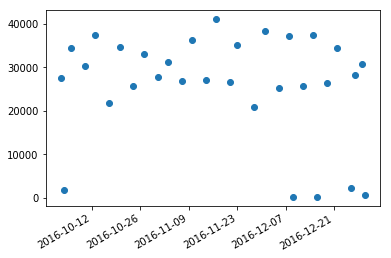

In [18]:
import matplotlib.pyplot as plt
# We will plot the data values and set the linestyle to 'None' which will not plot the line. We also want to show the individual data points, so we set the marker.
plt.plot(topstoredf['SalesDate'].values, topstoredf['SalesToStore'].values, linestyle='None', marker='o')
# autofmt_xdate() tells the computer that it should treat the x-values as dates and format them appropriately. This is a figure function, so we use gcf() to "get current figure"
plt.gcf().autofmt_xdate()

### A Second dataset

Now we need another dataset to work with. Let's try pulling the Dow Jones Industrial average index for each day. We'll download the data from [here](https://fred.stlouisfed.org/series/DJIA/downloaddata). We will also use a nice tool in the `read_csv()` function: it can parse a date column and put it in the appropriate datetime format all in one step.

In [19]:
djiadf = pd.read_csv('Class05_DJIA_data.csv',parse_dates=[0])
print(djiadf.dtypes)
djiadf.head()

DATE     datetime64[ns]
VALUE           float64
dtype: object


,DATE,VALUE
0,2016-10-03,18253.85
1,2016-10-04,18168.45
2,2016-10-05,18281.03
3,2016-10-06,18268.50
4,2016-10-07,18240.49


In [20]:
# We'll rename the second column to something a little more descriptive
djiadf.rename(columns={'VALUE':'DowJonesAvg'},inplace=True)
#Let's check for problems:
djiadf.isnull().values.any()

True

In [21]:
# Looks like there are two problem rows. Let's identify which rows by indexing the dataframe on the isnull() data
djiadf[djiadf['DowJonesAvg'].isnull()]

,DATE,DowJonesAvg
38,2016-11-24,NaN
60,2016-12-26,NaN


In [22]:
# These were both holidays and shouldn't be included in the data set anyway! We can drop them in place, modifying our dataframe.
djiadf.dropna(inplace=True)
djiadf.isnull().values.any()

False

And, of course, let's plot it to see what it looks like.

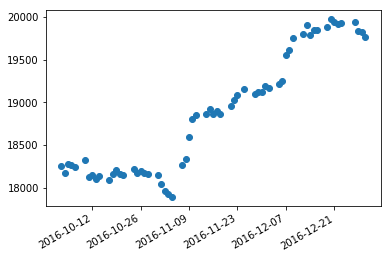

In [23]:
# We will plot the data values and set the linestyle to 'None' which will not plot the line. We also want to show the individual data points, so we set the marker.
plt.plot(djiadf['DATE'].values, djiadf['DowJonesAvg'].values, linestyle='None', marker='o')
# autofmt_xdate() tells the computer that it should treat the x-values as dates and format them appropriately. This is a figure function, so we use gcf() to "get current figure"
plt.gcf().autofmt_xdate()

## Joining Data

We now want to join the data from the store and the Dow Jones Industrial average. This will let us plot the two together to see if there is any correlation between the DJIA and the purchases that the store is making.

In order to join two dataframes we need to know how to align the rows or how to match up the data. The easiest way to do this is to try it out with an example to see how it works. We are going to follow [this tutorial](http://chrisalbon.com/python/pandas_join_merge_dataframe.html) on merging data in pandas. We start by creating two small test dataframes.

In [24]:
raw_data = {
        'patient_id': ['A', 'B', 'C', 'D', 'E'],
        'first_name': ['Alex', 'Amy', 'Allen', 'Alice', 'Ayoung'], 
        'last_name': ['Anderson', 'Ackerman', 'Ali', 'Aoni', 'Atiches'],
        'visit_number': [1,2,3,4,5],}
df_a = pd.DataFrame(raw_data, columns = ['patient_id', 'first_name', 'last_name','visit_number'])
df_a

,patient_id,first_name,last_name,visit_number
0,A,Alex,Anderson,1
1,B,Amy,Ackerman,2
2,C,Allen,Ali,3
3,D,Alice,Aoni,4
4,E,Ayoung,Atiches,5


In [25]:
raw_data = {
        'doctor_id': ['G', 'H', 'I', 'A', 'B'],
        'first_name': ['Billy', 'Brian', 'Bran', 'Bryce', 'Betty'], 
        'last_name': ['Bonder', 'Black', 'Balwner', 'Brice', 'Btisan'],
        'visit_number': [4,5,6,7,8]}
df_b = pd.DataFrame(raw_data, columns = ['doctor_id', 'first_name', 'last_name','visit_number'])
df_b

,doctor_id,first_name,last_name,visit_number
0,G,Billy,Bonder,4
1,H,Brian,Black,5
2,I,Bran,Balwner,6
3,A,Bryce,Brice,7
4,B,Betty,Btisan,8


How do we tack `df_b` on the end of `df_a`? This is useful if you have pieces of a dataset that you want to combine together. Note that pandas doesn't, by default, reset the index for the new dataframe. We'd have to do that afterwards if we want to. Notice that there are now `NaN` values in the table! The first dataframe didn't have the `doctor_id` column, so pandas filled in those values with `NaN`. Same for the second dataframe and the `patient_id` values. We could drop those columns if we wanted to.

In [26]:
pd.concat([df_a, df_b])

,doctor_id,first_name,last_name,patient_id,visit_number
0,NaN,Alex,Anderson,A,1
1,NaN,Amy,Ackerman,B,2
2,NaN,Allen,Ali,C,3
3,NaN,Alice,Aoni,D,4
4,NaN,Ayoung,Atiches,E,5
0,G,Billy,Bonder,NaN,4
1,H,Brian,Black,NaN,5
2,I,Bran,Balwner,NaN,6
3,A,Bryce,Brice,NaN,7
4,B,Betty,Btisan,NaN,8


What if we want to join together the rows that have the same visit_number? Looking at the table, we see that Billy Bonder and Alice Aoni have the same `visit_number`. Let's merge the two dataframes together to see how that works.

In [27]:
pd.merge(df_a,df_b,on='visit_number')

,patient_id,first_name_x,last_name_x,visit_number,doctor_id,first_name_y,last_name_y
0,D,Alice,Aoni,4,G,Billy,Bonder
1,E,Ayoung,Atiches,5,H,Brian,Black


So we now have a much smaller dataframe that only has the rows where `visit_number` was the same in both. Note that pandas also has changed the column names. This is because there were duplicate names and it can't have that to maintain unique addressing. Look at [the documentation for pandas](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) to see how to change the suffixes that pandas appends.

What if, instead, we wanted to merge rows where the `patient_id` from one matches the `doctor_id` from the other? We can do that, too. The two dataframes are given the designations **left** and **right** for the first and second dataframes, respectively. So we need to identify the columns in each to match.

In [28]:
pd.merge(df_a,df_b,left_on='patient_id',right_on='doctor_id')

,patient_id,first_name_x,last_name_x,visit_number_x,doctor_id,first_name_y,last_name_y,visit_number_y
0,A,Alex,Anderson,1,A,Bryce,Brice,7
1,B,Amy,Ackerman,2,B,Betty,Btisan,8


What if we want to keep *all* of the entries in the left dataframe and only add in values on the right where they match? We can do that, too!

In [29]:
pd.merge(df_a,df_b,on='visit_number', how='left')

,patient_id,first_name_x,last_name_x,visit_number,doctor_id,first_name_y,last_name_y
0,A,Alex,Anderson,1,NaN,NaN,NaN
1,B,Amy,Ackerman,2,NaN,NaN,NaN
2,C,Allen,Ali,3,NaN,NaN,NaN
3,D,Alice,Aoni,4,G,Billy,Bonder
4,E,Ayoung,Atiches,5,H,Brian,Black


Not surprisingly, we can do the right-side, too.

In [30]:
pd.merge(df_a,df_b,on='visit_number', how='right')

,patient_id,first_name_x,last_name_x,visit_number,doctor_id,first_name_y,last_name_y
0,D,Alice,Aoni,4,G,Billy,Bonder
1,E,Ayoung,Atiches,5,H,Brian,Black
2,NaN,NaN,NaN,6,I,Bran,Balwner
3,NaN,NaN,NaN,7,A,Bryce,Brice
4,NaN,NaN,NaN,8,B,Betty,Btisan


Finally, we can do both and include all the data from both dataframes, matching where possible. That is called an "outer" join.

In [31]:
pd.merge(df_a,df_b,on='visit_number', how='outer')

,patient_id,first_name_x,last_name_x,visit_number,doctor_id,first_name_y,last_name_y
0,A,Alex,Anderson,1,NaN,NaN,NaN
1,B,Amy,Ackerman,2,NaN,NaN,NaN
2,C,Allen,Ali,3,NaN,NaN,NaN
3,D,Alice,Aoni,4,G,Billy,Bonder
4,E,Ayoung,Atiches,5,H,Brian,Black
5,NaN,NaN,NaN,6,I,Bran,Balwner
6,NaN,NaN,NaN,7,A,Bryce,Brice
7,NaN,NaN,NaN,8,B,Betty,Btisan


#### Choosing the Merge Index

How do you choose the merge index? We used both the `visit_number` and the `patient/doctor_id` values. The key is to be able to merge on some common feature. This may be date (like we show below), but it could also be on zip code, a city name, the month number, financial quarter, or any other piece of information that you have common between your two datasets. You need to make sure that the merge indices have the same data type and are in the same format. For example, the computer doesn't know that 'DALLAS' and 'Dallas' are the same city. We can use the tools we've previously covered to clean up the data prior to attempting the merge.

## Merging the Store and DJIA data

Since we want to keep all of the store data and merge in the DJIA data where we can, we are going to try a left join. We are also going to try joining on the date - they should match up reasonably well.

In [32]:
storeDJ = pd.merge(topstoredf, djiadf, left_on='SalesDate',right_on='DATE',how='left')
storeDJ.head()

,SalesToStore,SalesDate,DATE,DowJonesAvg
0,27592.98,2016-10-03,2016-10-03,18253.85
1,1621.20,2016-10-04,2016-10-04,18168.45
2,34386.10,2016-10-06,2016-10-06,18268.50
3,30216.88,2016-10-10,2016-10-10,18329.04
4,37319.85,2016-10-13,2016-10-13,18098.94


Now we can do what we wanted to do: plot the data to see if there is a correlation here!

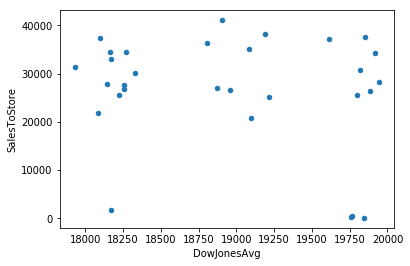

In [33]:
storeDJ.plot.scatter(x='DowJonesAvg',y='SalesToStore')

Well, after all that work, it doesn't look like there is anything there... Perhaps that isn't too surprising as the purchases by a single store may not depend on a macro-scale indicator like the Dow Jones Industrial average. But we didn't know that until we checked.


## In-class Activity

Instead of looking at the sales to one store, what if we look at the total sales to all of the stores in the state of Iowa? Go through the process of grouping that data and joining it with the DJIA data. Plot the results and show me before you leave.

# Assignment

Your assignment this week is to do data enriching on your dataset. You can either add/join data or do some kind of grouping to subset the data. I want documentation of what you did and how it turned out. Like our example today, you may find that the data enriching doesn't do much.
